In [ ]:
# Filter the laws dataset for entries that are likely to be related to CO2 emission reductions
# We look for keywords in the Title or Text columns that might indicate relevance
import pandas as pd

# Load the dataset
laws_df = pd.read_csv('/content/state_laws_and_incentives.csv')


keywords = ['CO2', 'emission', 'carbon', 'greenhouse', 'clean air', 'renewable energy']

# Lowercase the text for case-insensitive matching
laws_df['Title_lower'] = laws_df['Title'].str.lower()
laws_df['Text_lower'] = laws_df['Text'].str.lower()

# Filter rows where any keyword is found in either the Title or Text
filtered_laws_df = laws_df[
    laws_df.apply(lambda x: any(keyword in x['Title_lower'] or keyword in x['Text_lower'] for keyword in keywords), axis=1)
]

# We'll also remove entries that don't have a specific state associated with them to focus on state-level policies
filtered_state_laws_df = filtered_laws_df[filtered_laws_df['State'] != 'US']

filtered_state_laws_df[['Law Id', 'State', 'Title', 'Enacted Date', 'Amended Date']].head()


,Law Id,State,Title,Enacted Date,Amended Date
0,202,CO,Low Emission Vehicle (LEV) Sales Tax Exemption,NaN,2014-06-06 00:00:00 UTC
37,4178,AZ,Zero Emission Vehicle Emissions Test Exemption,2016-01-01 00:00:00 UTC,NaN
39,4216,CA,Air Quality Improvement Program Funding - Vent...,NaN,NaN
40,4219,CA,Employer Invested Emissions Reduction Funding ...,NaN,NaN
43,4249,CA,Zero Emission Vehicle (ZEV) Production Require...,NaN,2022-11-01 00:00:00 UTC


In [ ]:
import numpy as np

emissions_df = pd.read_csv('/content/emissions_per_capita_by_state_renamed.csv')

# Calculate the annual percentage change in emissions for each state
emissions_pct_change = emissions_df.set_index('STATE').pct_change(axis=1)

# Calculate the mean annual percentage change for each state over the entire period
mean_annual_pct_change = emissions_pct_change.mean(axis=1)

# Identify states with the most significant average annual reduction in emissions
# We sort states by their mean annual percentage change in emissions
significant_reduction_states = mean_annual_pct_change.sort_values().head(5).index.tolist()

# Display states with significant reductions and their mean annual percentage change
significant_reduction_states, mean_annual_pct_change.loc[significant_reduction_states]


(['MS', 'OR', 'AR', 'ME', 'NV'],
 STATE
 MS   -0.844800
 OR   -0.120997
 AR   -0.105526
 ME   -0.089642
 NV   -0.021583
 dtype: float64)

In [ ]:
# Calculate the total change in emissions for each state from 1990 to 2021
emissions_df['Total_Change'] = emissions_df['Y2019'] - emissions_df['Y1990']

# Sort the states by their total change in emissions to identify those with the greatest reductions
states_with_greatest_reductions = emissions_df[['STATE', 'Total_Change']].sort_values(by='Total_Change')

# Display the states with the top 5 reductions in emissions
states_with_greatest_reductions.head(5)


,STATE,Total_Change
49,WY,-0.000036
31,NM,-0.000015
43,UT,-0.000013
32,NV,-0.000013
7,DE,-0.000012


In [ ]:
import pandas as pd

# Load your dataset into laws_df
# laws_df = pd.read_csv('path_to_your_file.csv')

# Filter for New York (NY) state policies and create a copy to avoid SettingWithCopyWarning
#try california instead - from NY to CA
ny_policies = laws_df[(laws_df['State'] == 'FL') &
                      (laws_df['Title'].str.lower().str.contains('emission|carbon|greenhouse|clean air|renewable'))
                     ].copy()

# Convert Enacted and Amended Dates to datetime and address timezone-awareness
ny_policies['Enacted Date'] = pd.to_datetime(ny_policies['Enacted Date'], errors='coerce').dt.tz_localize(None)
ny_policies['Amended Date'] = pd.to_datetime(ny_policies['Amended Date'], errors='coerce').dt.tz_localize(None)

# Filter policies enacted or amended within 1990-2021
ny_policies_filtered = ny_policies[
    ((ny_policies['Enacted Date'] >= pd.Timestamp('1990-01-01')) & (ny_policies['Enacted Date'] <= pd.Timestamp('2019-12-31'))) |
    ((ny_policies['Amended Date'] >= pd.Timestamp('1990-01-01')) & (ny_policies['Amended Date'] <= pd.Timestamp('2019-12-31')))
]

# Selecting relevant columns to display
ny_policies_relevant = ny_policies_filtered[['Law Id', 'State', 'Title', 'Enacted Date', 'Amended Date', 'Text']]

# Display the filtered DataFrame
print(ny_policies_relevant)


     Law Id State                                     Title Enacted Date  \
355    6424    FL  Provision for Renewable Fuels Investment   2008-05-21   

    Amended Date                                               Text  
355          NaT  To create jobs and improve the state's general...  


In [ ]:
import pandas as pd

# Assuming emissions_df is already loaded with the emissions data
# Filter for New York's emissions data
ny_emissions = emissions_df[emissions_df['STATE'] == 'FL']

# Convert the wide format to long format for easier calculations
ny_emissions_long = ny_emissions.melt(id_vars=['STATE'], var_name='Year', value_name='Emissions')
ny_emissions_long['Year'] = ny_emissions_long['Year'].str.extract('(\d+)')[0]  # Extract year as string

# Convert Year to integer and Emissions to float
# Using pd.to_numeric for safe conversion and handling NaNs
ny_emissions_long['Year'] = pd.to_numeric(ny_emissions_long['Year'], errors='coerce')
ny_emissions_long['Emissions'] = pd.to_numeric(ny_emissions_long['Emissions'], errors='coerce')

# Ensure rows with NaN in 'Year' or 'Emissions' are handled (if any)
ny_emissions_long.dropna(subset=['Year', 'Emissions'], inplace=True)

# Convert 'Year' to integer now that NaNs are handled
ny_emissions_long['Year'] = ny_emissions_long['Year'].astype(int)

# Calculate the year-to-year percentage change in emissions
ny_emissions_long.sort_values(by='Year', inplace=True)  # Sort by year
ny_emissions_long['Pct_Change'] = ny_emissions_long['Emissions'].pct_change() * 100


print(ny_emissions_long)

   STATE  Year  Emissions  Pct_Change
0     FL  1990   0.000013         NaN
1     FL  1991   0.000013   -1.492427
2     FL  1992   0.000013   -0.456561
3     FL  1993   0.000013    2.942633
4     FL  1994   0.000013    0.718462
5     FL  1995   0.000014    1.118741
6     FL  1996   0.000014    1.579710
7     FL  1997   0.000014   -0.394706
8     FL  1998   0.000014    4.911158
9     FL  1999   0.000014   -3.776344
10    FL  2000   0.000014   -1.851709
11    FL  2001   0.000014    0.523551
12    FL  2002   0.000014    0.331615
13    FL  2003   0.000014    0.980364
14    FL  2004   0.000014    0.628632
15    FL  2005   0.000014   -1.055308
16    FL  2006   0.000013   -2.825909
17    FL  2007   0.000013   -2.011313
18    FL  2008   0.000012   -7.219249
19    FL  2009   0.000011   -6.485299
20    FL  2010   0.000012    5.798720
21    FL  2011   0.000011   -7.085530
22    FL  2012   0.000011   -3.006996
23    FL  2013   0.000011   -1.679896
24    FL  2014   0.000011    1.315750
25    FL  20

In [ ]:
# Define the policy enactment years from the previous filtering step
policy_years = [2008]  # Example years based on the policies listed previously

# Identify percentage changes in emissions around the policy years
for year in policy_years:
    pct_change_near_year = ny_emissions_long.loc[ny_emissions_long['Year'].isin([year-1, year, year+1]), :]
    print(f"Percentage Change in Emissions Around {year}:")
    print(pct_change_near_year[['Year', 'Pct_Change']])
    print("\n")


Percentage Change in Emissions Around 2008:
    Year  Pct_Change
17  2007   -2.011313
18  2008   -7.219249
19  2009   -6.485299




In [ ]:
#Focus on the Zero Emission Vehicle (ZEV) Sales Requirements policy

In [ ]:
# Assuming laws_df contains the laws and incentives data
# Filter for policies related to ZEV by keywords in the title
zev_related_policies = laws_df[laws_df['Title'].str.contains('Renewable Fuels', case=False, na=False)]

# Get unique states that have ZEV-related policies enacted between 2011 and 2021
zev_policy_states = zev_related_policies[
    ((zev_related_policies['Enacted Date'] >= '2008') & (zev_related_policies['Enacted Date'] <= '2019')) |
    ((zev_related_policies['Amended Date'] >= '2008') & (zev_related_policies['Amended Date'] <= '2019'))
]['State'].unique()

# Assuming 'NY' will be in this list, we remove it since it's our treated unit
zev_policy_states = [state for state in zev_policy_states if state != 'FL']

print("States with similar ZEV-related policies enacted between 2008 and 2021:", zev_policy_states)


States with similar ZEV-related policies enacted between 2008 and 2021: ['OR', 'PA']


In [ ]:
# Assuming emissions_df is your emissions data
all_states = emissions_df['STATE'].unique()

# Excluding states with ZEV-related policies and New York (NY)
control_states = [state for state in all_states if state not in zev_policy_states and state != 'FL']

print("Potential control states:", control_states)


Potential control states: ['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DE', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']


In [ ]:
# Convert the wide format emissions data to long format for easier manipulation
emissions_long = emissions_df.melt(id_vars=['STATE'], var_name='Year', value_name='Emissions')
emissions_long['Year'] = pd.to_numeric(emissions_long['Year'].str.extract('(\d+)')[0])

# Filter for years up to 2011 (pre-intervention) and for selected states
pre_intervention_data = emissions_long[
    (emissions_long['Year'] <= 2008) &
    (emissions_long['STATE'].isin(['FL'] + control_states))
]

# Ensure emissions are in the correct data type
pre_intervention_data['Emissions'] = pd.to_numeric(pre_intervention_data['Emissions'], errors='coerce')


<ipython-input-9-29e5510f98cd>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_intervention_data['Emissions'] = pd.to_numeric(pre_intervention_data['Emissions'], errors='coerce')


In [ ]:
# Pivot the DataFrame to have years as columns and states as rows
pre_intervention_pivot = pre_intervention_data.pivot(index='STATE', columns='Year', values='Emissions')

# Display the pivoted DataFrame
print(pre_intervention_pivot.head())


Year         1990.0        1991.0    1992.0        1993.0    1994.0    1995.0  \
STATE                                                                           
AK     4.957328e-05  3.854538e-05  0.000024  2.647673e-05  0.000026  0.000032   
AL     1.447312e-05  1.531227e-05  0.000017  1.761994e-05  0.000017  0.000019   
AR    -4.859711e-08 -1.411474e-07  0.000001  8.736751e-07  0.000003  0.000005   
AZ     1.875453e-05  1.805932e-05  0.000018  1.843979e-05  0.000018  0.000016   
CA     1.043567e-05  9.874367e-06  0.000010  9.712587e-06  0.000010  0.000010   

Year     1996.0    1997.0    1998.0    1999.0    2000.0    2001.0    2002.0  \
STATE                                                                         
AK     0.000037  0.000031  0.000043  0.000047  0.000045  0.000039  0.000085   
AL     0.000020  0.000020  0.000020  0.000021  0.000022  0.000020  0.000021   
AR     0.000006  0.000006  0.000007  0.000008  0.000008  0.000008  0.000007   
AZ     0.000017  0.000017  0.000018  

In [ ]:
from sklearn.linear_model import LinearRegression

# Prepare the data: New York as 'y' and control states as 'X'
X = pre_intervention_pivot.loc[control_states].fillna(0)  # Control states' emissions, filling any NaNs with 0
y = pre_intervention_pivot.loc['FL'].fillna(0)  # New York's emissions, filling any NaNs with 0

# Fit a linear model
model = LinearRegression(fit_intercept=False)  # No intercept to mimic sum(weights) = 1
model.fit(X.T, y)

# The model coefficients can serve as an approximation of the weights
weights = model.coef_
print("Approximate weights for control states:", weights)


Approximate weights for control states: [-0.00066533  0.08410623 -0.05643632 -0.0264319   0.02698269  0.03378102
 -0.03650644  0.04382668  0.11461774  0.03558824 -0.00645676 -0.03878395
 -0.06875803 -0.01816672  0.01366253  0.02045815  0.03174012  0.00266551
  0.05877755  0.03758807  0.00353754  0.05257552  0.15209862 -0.03579512
  0.04034005 -0.07238428  0.0086491   0.16225863  0.05572078 -0.00721852
  0.00603611 -0.00471407 -0.00641266 -0.03981652 -0.1395869   0.0621051
  0.05052287 -0.11443354  0.00564795  0.06902015  0.06190927  0.0345334
  0.00025262  0.00455478 -0.01064835 -0.00675735 -0.00516487]


In [ ]:
import numpy as np
import cvxpy as cp

X_np = X.values

# Number of control units (states)
n = X_np.shape[0]

# Define the weights variable with 'n' elements
w = cp.Variable((n, 1))  # Explicitly define 'w' as a column vector

# Convert 'y' from a pandas Series to a 2D numpy array if it's not already
if isinstance(y, pd.Series):
    y_np = y.to_numpy().reshape(-1, 1)
else:
    y_np = y  # Assuming 'y' is already a numpy array with shape (21, 1)

# Now, re-define the objective function with the correct shapes
objective = cp.Minimize(cp.norm(X_np.T @ w - y_np, 'fro'))

# Redefine the constraints and problem as before
constraints = [w >= 0, cp.sum(w) == 1]
prob = cp.Problem(objective, constraints)
prob.solve()

# Extract the optimized weights, ensuring they are flattened for later use
optimized_weights = w.value.flatten()  # Use flatten to create a 1D array

print("Optimized weights for control states:", optimized_weights)


Optimized weights for control states: [6.67115262e-07 1.06057798e-06 4.37421351e-07 1.56785697e-06
 1.82651259e-01 1.33087760e-06 1.49489086e-06 1.87707602e-02
 8.96353474e-02 1.06696380e-01 7.38426994e-07 2.67021239e-02
 7.11205964e-07 3.98367998e-07 7.30194627e-07 4.98986563e-07
 2.78165231e-07 2.85173571e-04 1.68672327e-01 4.19473218e-02
 1.76261588e-06 3.95254479e-06 1.95095712e-06 6.38591184e-07
 1.02157041e-06 1.09336412e-06 2.25463948e-07 1.13381379e-01
 3.06405180e-06 8.57580483e-07 5.51848217e-07 2.02239777e-02
 7.22150658e-06 9.02817659e-07 3.77976919e-07 4.63160072e-02
 1.17926345e-06 4.09949602e-07 1.68768049e-06 7.59465830e-02
 1.10465132e-05 1.48875676e-06 1.08714975e-01 5.58368590e-06
 1.00854105e-06 3.41939027e-07 1.03288704e-07]


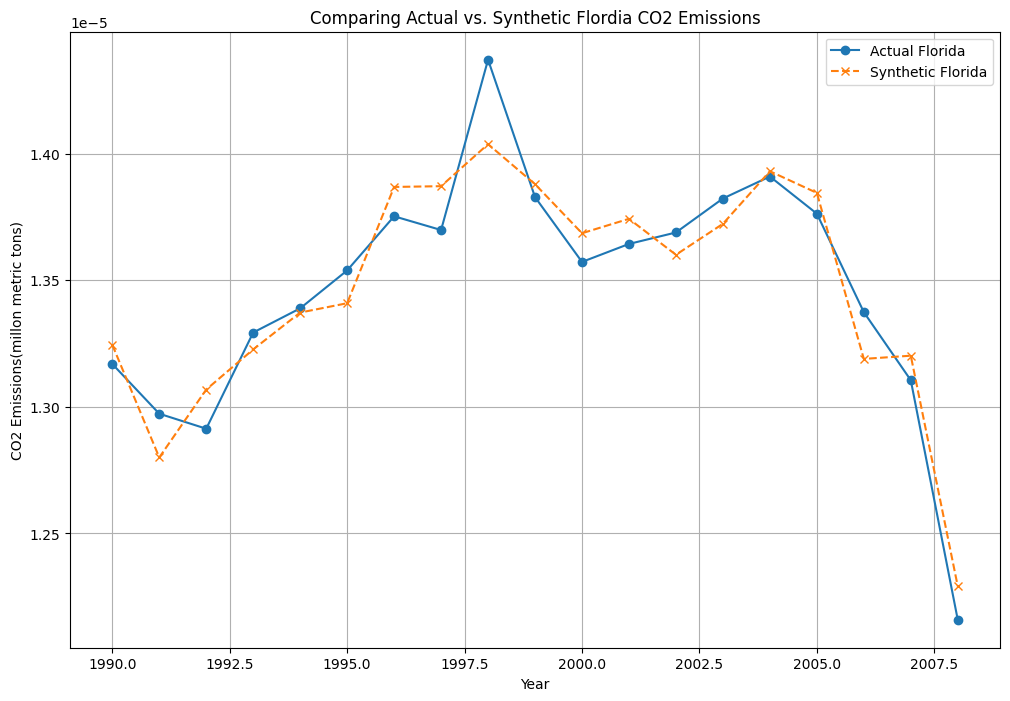

In [ ]:
# Ensure 'optimized_weights' is correctly shaped as (33,) for the dot operation
optimized_weights_reshaped = optimized_weights.flatten()

# Correct the dot product operation
synthetic_ny_emissions = np.dot(X.values.T, optimized_weights_reshaped)

# Convert the pandas Series 'y' to a numpy array and flatten it
actual_ny_emissions = y.to_numpy().flatten()

# Assuming 'years' is a numpy array or a list
years = pre_intervention_pivot.columns.to_numpy()

# The rest of your plotting code seems correct
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.plot(years, actual_ny_emissions, label='Actual Florida', marker='o')
plt.plot(years, synthetic_ny_emissions, label='Synthetic Florida', linestyle='--', marker='x')
plt.title('Comparing Actual vs. Synthetic Flordia CO2 Emissions')
plt.xlabel('Year')
plt.ylabel('CO2 Emissions(millon metric tons)')
plt.legend()
plt.grid(True)
plt.show()



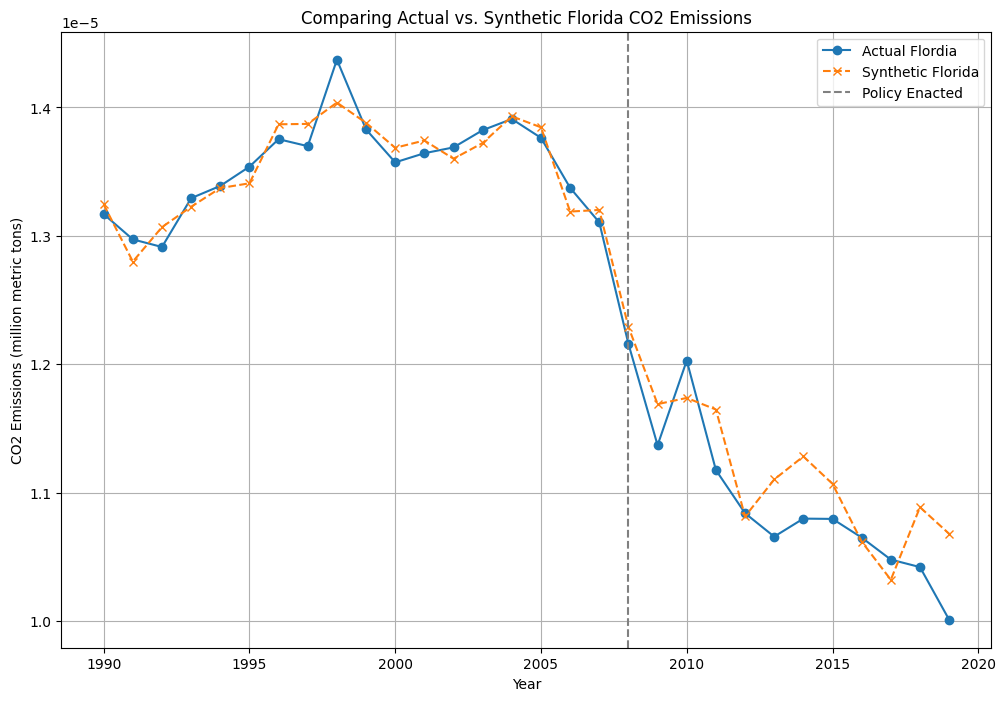

In [ ]:
# Extend the analysis to the post-intervention period.
# Assuming you have the emissions data for the control states and New York for the years after 2011

# Post-intervention emissions data for the control states and New York
post_intervention_data = emissions_long[
    (emissions_long['Year'] > 2008) &
    (emissions_long['STATE'].isin(['FL'] + control_states))
]

# Pivot this data similarly to before
post_intervention_pivot = post_intervention_data.pivot(index='STATE', columns='Year', values='Emissions')

# Get the actual post-intervention emissions for New York
actual_post_ny_emissions = post_intervention_pivot.loc['FL']

# Predict the synthetic post-intervention emissions for New York using the control states and optimized weights
synthetic_post_ny_emissions = np.dot(post_intervention_pivot.loc[control_states].fillna(0).values.T, optimized_weights_reshaped)

# Now we plot both pre-intervention and post-intervention actual vs. synthetic emissions

# Combine pre and post data
all_years = np.concatenate((years, post_intervention_pivot.columns))
all_actual_emissions = np.concatenate((actual_ny_emissions, actual_post_ny_emissions.values))
all_synthetic_emissions = np.concatenate((synthetic_ny_emissions, synthetic_post_ny_emissions))

plt.figure(figsize=(12, 8))
plt.plot(all_years, all_actual_emissions, label='Actual Flordia', marker='o')
plt.plot(all_years, all_synthetic_emissions, label='Synthetic Florida', linestyle='--', marker='x')
plt.axvline(x=2008, color='grey', linestyle='--', label='Policy Enacted')  # Line indicating policy enactment
plt.title('Comparing Actual vs. Synthetic Florida CO2 Emissions')
plt.xlabel('Year')
plt.ylabel('CO2 Emissions (million metric tons)')
plt.legend()
plt.grid(True)
plt.show()
